In [194]:
from pulp import * 
currentdir = os.path.dirname(os.path.realpath("__file__"))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 
import utils

#python C:\Program Files\IBM\ILOG\CPLEX_Studio221\python\setup.py install
instance=utils.loadInstance("../instances/ins-15.txt")
print(listSolvers(onlyAvailable=True))
print(*[f" {key} = {val}\n" for key,val in instance.items()])

No parameters matching '_test' found
['CPLEX_CMD', 'CPLEX_PY', 'GUROBI', 'PULP_CBC_CMD']
 n = 16
  w = 22
  dim = [[3, 3], [3, 4], [3, 5], [3, 6], [3, 7], [3, 8], [3, 9], [3, 10], [3, 11], [3, 12], [3, 13], [3, 14], [3, 22], [4, 3], [4, 19], [6, 4]]



c:\Users\tomma\Documents\Uni\Magistrale\pyvenvs\CDMO_venv\lib\site-packages\pulp\apis\gurobi_api.py:357: UserWarning: GUROBI error: Set parameter LogFile to value "gurobi.log"

Failed to set up a license

Error 10009: No Gurobi license found (user tomma, host LAPTOP_CORTE, hostid 9e2327a6, cores 4)


.
  warnings.warn("GUROBI error: {}.".format(out))


In [195]:
#PARAMETERS
M=1000
WC=instance["w"]
n=instance["n"]
p=[i[0] for i in instance["dim"]]
q=[i[1] for i in instance["dim"]]
Hmax=sum(q)

# DECISION VARIABLES
W=[] # Width of block
H=[] # Height of block
Xl=[] # left boundary of block
Xr=[] # right boundary of block
Yt=[] # top boundary of block
Yb=[] # bottom boundary of block
R=[] # 0 if block i is to the left of block j
U=[] # 0 if block i is below block j
V=[] # rotations
tot_area=sum([w_i*h_i for w_i,h_i in zip(p,q)])
Hmin = tot_area/WC
import numpy as np
biggest_i=np.argmax([p[i]*q[i] for i in range(n)])
print(Hmin,Hmax)
HC=LpVariable(f"H_c",Hmin,Hmax,LpInteger)
for i in range(n):
    W.append(LpVariable(f"W_{i}",0,None,LpInteger))
    H.append(LpVariable(f"H_{i}",0,None,LpInteger))
    Xl.append(LpVariable(f"Xl_{i}",0,None,LpInteger))
    Xr.append(LpVariable(f"Xr_{i}",0,None,LpInteger))
    Yt.append(LpVariable(f"Yt_{i}",0,None,LpInteger))
    Yb.append(LpVariable(f"Yb_{i}",0,None,LpInteger))
    V.append(LpVariable(f"V_{i}",0,1,LpInteger))
    tempR=[]
    tempU=[]
    for j in range(n):
        if i!=j: 
            tempR.append(LpVariable(f"R_{i}_{j}",0,1,LpInteger))
            tempU.append(LpVariable(f"U_{i}_{j}",0,1,LpInteger))
        else:
            tempR.append(None)
            tempU.append(None)
    R.append(tempR)
    U.append(tempU)


22.0 150


In [182]:
def buildProblem():
    # PROBLEM FORMULATION    
    problem=LpProblem("VLSI_Problem", LpMinimize)

    problem += HC, "Chip_Height"
    # problem += HC*WC-tot_area >=0 ,"Empty_space"

    for i in range(n):
        problem += Xr[i]-Xl[i]==W[i], f"B_{i}_boundaries_LR"
        problem += Yt[i]-Yb[i]==H[i], f"B_{i}_boundaries_TB"
        problem += W[i]==p[i], f"B_{i}_width"
        problem += H[i]==q[i], f"B_{i}_heigth"
        problem += Yt[i]<=HC,  f"Max_{i}_ytpos"
        problem += Yt[i]>=q[i], f"Min_{i}_ybpos"
        #problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
        #problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
        for j in range(n):
            problem += Yt[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"
            problem += Xr[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
            if i!=j:
                problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"
                problem += Xr[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
                problem += Yt[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
    return problem

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
Tried aggregator 2 times.
MIP Presolve eliminated 529 rows and 20 columns.
MIP Presolve modified 675 coefficients.
Aggregator did 10 substitutions.
Reduced MIP has 611 rows, 483 columns, and 1917 nonzeros.
Reduced MIP has 450 binaries, 33 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.13 ticks)
Found incumbent of value 90.000000 after 0.01 sec. (5.05 ticks)
Probing time = 0.00 sec. (0.84 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 611 rows, 483 columns, and 1917 nonzeros.
Reduced MIP has 450 binaries, 33 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.37 ticks)
Probing time = 0.00 sec. (0.86 ticks)
Clique table members: 325.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.00 sec. (3.91 ticks)

     

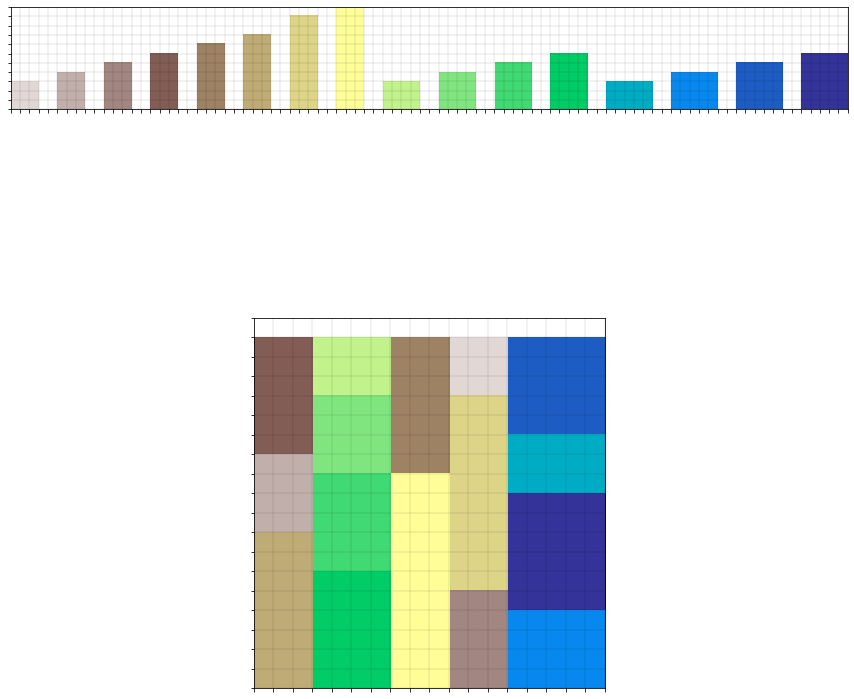

7


In [169]:
def buildProblem():
    # PROBLEM FORMULATION    
    problem=LpProblem("VLSI_Problem", LpMinimize)

    problem += HC, "Chip_Height"
    #  problem += HC*WC-tot_area >=0 ,"Empty_space"
    problem += 2*Xl[biggest_i]<=WC-p[biggest_i], "Largest_rectangle_Xpos"
    problem += 2*Yb[biggest_i]<=HC-q[biggest_i], "Largest_rectangle_Ypos"
    for i in range(n):
        problem += Yb[i]+q[i]<=HC,  f"Max_{i}_Ypos"
        #problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
        #problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
        for j in range(n):
            problem += Xl[i]+p[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
            problem += Yb[i]+q[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"

            if i!=j:
                problem += Xl[i]+p[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
                problem += Yb[i]+q[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
                if p[i]+p[j]>WC:
                    problem+= R[i][j]==1,f"B_{i}_{j}_too_large"
            if i<j:
                problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"                    
                if p[i]==p[j] and q[i]==p[j]:  
                        problem+= R[i][j]==1,f"B_{i}_{j}_same_size_r"    
                        problem+= U[i][j]==1,f"B_{i}_{j}_same_size_u"        
    return problem
buildSolveShow()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 2 times.
MIP Presolve eliminated 535 rows and 24 columns.
MIP Presolve modified 669 coefficients.
Aggregator did 12 substitutions.
Reduced MIP has 607 rows, 477 columns, and 1901 nonzeros.
Reduced MIP has 444 binaries, 33 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (3.14 ticks)
Found incumbent of value 150.000000 after 0.02 sec. (5.02 ticks)
Probing time = 0.00 sec. (0.86 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 607 rows, 477 columns, and 1901 nonzeros.
Reduced MIP has 444 binaries, 33 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (1.33 ticks)
Probing time = 0.01 sec. (0.88 ticks)
Clique table members: 218.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root re

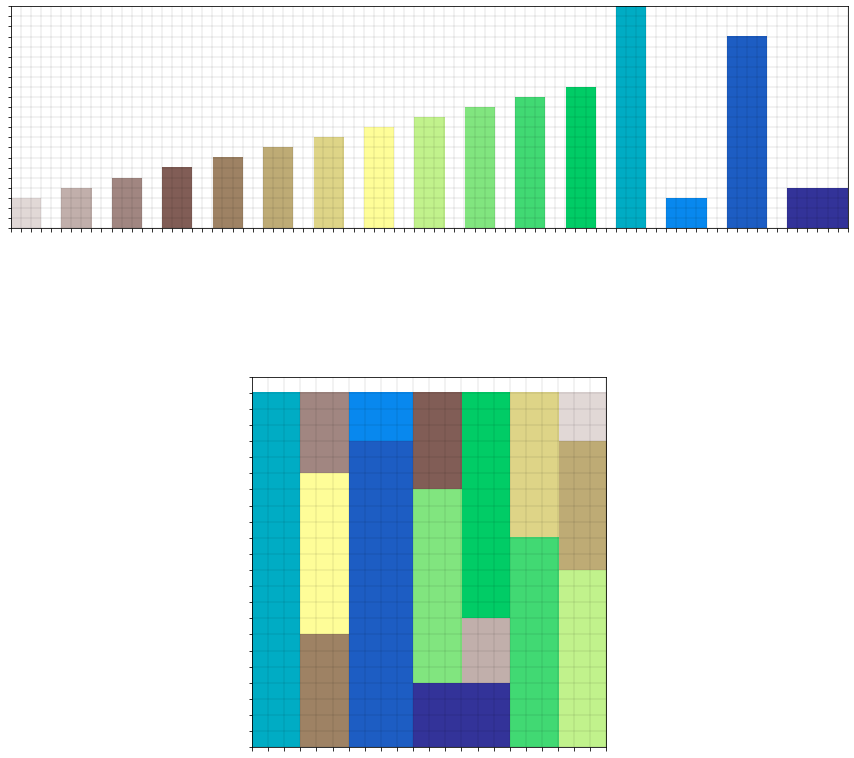

In [199]:
def buildProblem():
    # PROBLEM FORMULATION    
    problem=LpProblem("VLSI_Problem", LpMinimize)

    problem += HC, "Chip_Height"
    #  problem += HC*WC-tot_area >=0 ,"Empty_space"
    problem += 2*Xl[biggest_i]<=WC-p[biggest_i], "Largest_rectangle_Xpos"
    problem += 2*Yb[biggest_i]<=HC-q[biggest_i], "Largest_rectangle_Ypos"

    for i in range(n):
        problem += Yb[i]+q[i]<=HC,  f"Max_{i}_Ypos"
        #problem += W[i]== V[i]*p[i] + (1-V[i])*q[i], f"B_{i}_width"
        #problem += H[i]== (1-V[i])*p[i] + V[i]*q[i], f"B_{i}_height"
        for j in range(n):
            problem += Xl[i]+p[i]-Xl[j]<=WC,  f"B_{i}_{j}_width_less_than_chip"
            problem += Yb[i]+q[i]-Yb[j]<=HC,  f"B_{i}_{j}_height_less_than_chip"

            if i!=j:
                problem += Xl[i]+p[i]<=Xl[j]+M*R[i][j], f"B_{i}_{j}_non_overlap_horizontal"
                problem += Yb[i]+q[i]<=Yb[j]+M*U[i][j], f"B_{i}_{j}_non_overlap_vertical"
                if p[i]+p[j]>WC:
                    problem+= R[i][j]==1, f"B_{i}_{j}_too_large"
            if i<j:
                # if i==biggest_i and p[j]>=(WC-p[biggest_i])/2:
                #     problem += R[j][biggest_i]==1, "B_{i}_large"
                problem += R[i][j]+R[j][i]+U[i][j]+U[j][i]<=3, f"B_{i}_{j}_at_most_one_rel"  
                if p[i]==p[j] and q[i]==p[j]:  
                    problem+= R[i][j]==1,f"B_{i}_{j}_same_size_r"    
                    problem+= U[i][j]==1,f"B_{i}_{j}_same_size_u" 

                
    return problem
buildSolveShow()

Version identifier: 22.1.0.0 | 2022-03-09 | 1a383f8ce
CPXPARAM_Read_DataCheck                          1
CPXPARAM_TimeLimit                               300
Tried aggregator 2 times.
MIP Presolve eliminated 1668 rows and 10 columns.
MIP Presolve modified 2392 coefficients.
Aggregator did 4 substitutions.
Reduced MIP has 2079 rows, 1669 columns, and 6602 nonzeros.
Reduced MIP has 1610 binaries, 59 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.03 sec. (12.94 ticks)
Probing time = 0.00 sec. (2.67 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 2079 rows, 1669 columns, and 6602 nonzeros.
Reduced MIP has 1610 binaries, 59 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (4.49 ticks)
Probing time = 0.00 sec. (2.64 ticks)
Clique table members: 1094.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 8 threads.
Root relaxation solution time = 0.05 sec. (39.23 ticks)

      

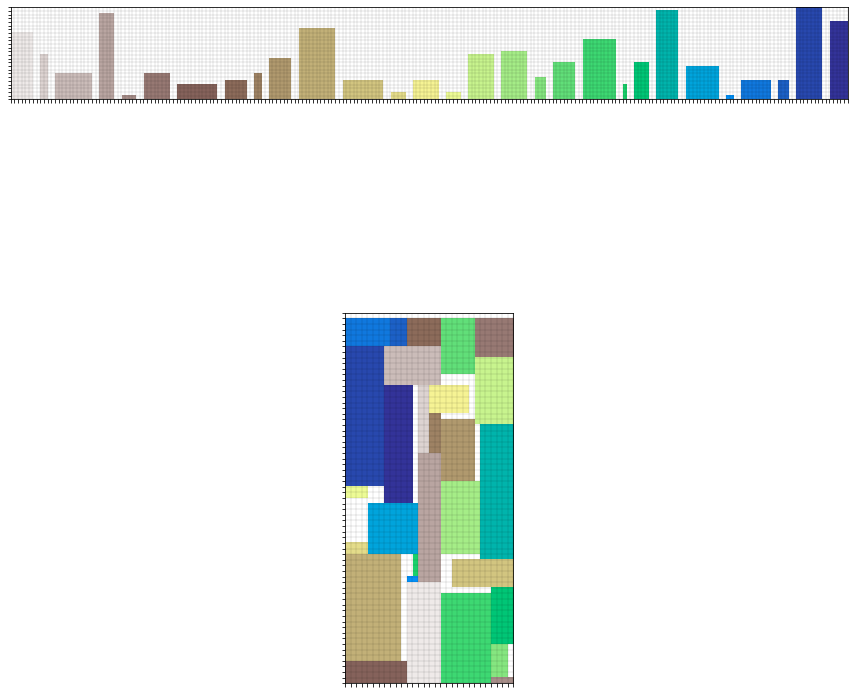

In [190]:
def buildSolveShow():
    problem=buildProblem()
    #print(problem)
    problem.solve(CPLEX_PY(timeLimit=300,msg=1))    
    solution=[[WC,int(HC.value())]]+[[p[i],q[i],round(Xl[i].value())+1,round(Yb[i].value())+1] for i in range(n)]
    print(solution)
    utils.show(solution,figsize=(15,15),lw=0.1)
buildSolveShow()

[[30, 65], [6, 18, 12, 1], [2, 12, 14, 42], [10, 7, 8, 54], [4, 23, 14, 19], [4, 1, 27, 1], [7, 7, 24, 59], [11, 4, 1, 1], [6, 5, 12, 61], [2, 7, 16, 42], [6, 11, 18, 37], [10, 19, 1, 5], [11, 5, 20, 18], [4, 2, 1, 24], [7, 5, 16, 49], [4, 2, 1, 34], [7, 12, 24, 47], [7, 13, 18, 24], [3, 6, 27, 2], [6, 10, 18, 56], [9, 16, 18, 1], [1, 4, 13, 20], [4, 10, 27, 8], [6, 24, 25, 23], [9, 9, 5, 24], [2, 1, 12, 19], [8, 5, 1, 61], [3, 5, 9, 61], [7, 25, 1, 36], [5, 21, 8, 33]]


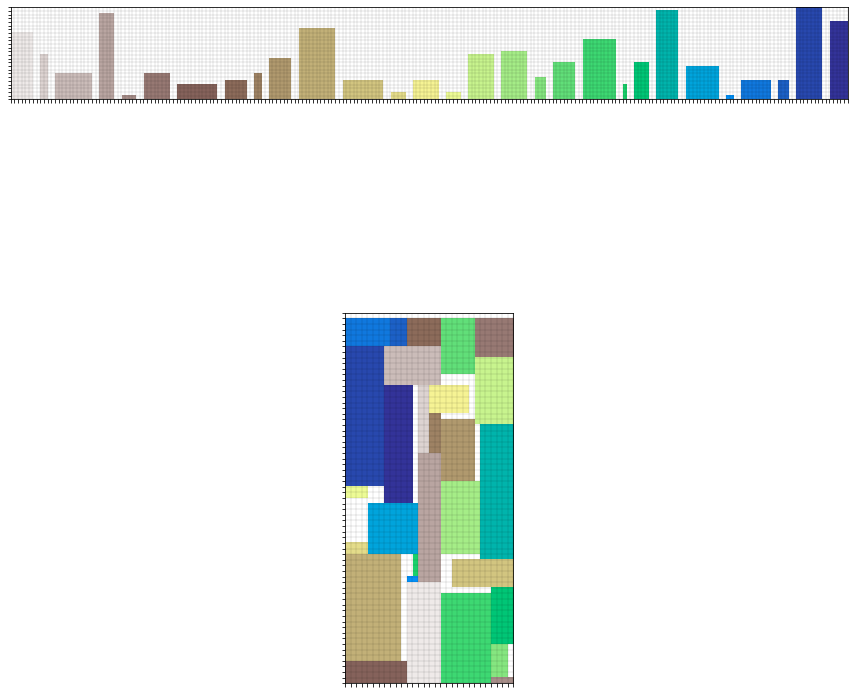

10


In [191]:
import matplotlib.pyplot as plt 
solution=[[WC,int(HC.value())]]+[[p[i],q[i],round(Xl[i].value())+1,round(Yb[i].value())+1] for i in range(n)]
print(solution)
utils.show(solution,figsize=(15,15),lw=0.1)
print(biggest_i)


In [150]:
print([y for y in q])
print([y.value() for y in Yb])
print()
print([y for y in p])
print([y.value() for y in Xl])


[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 22, 3, 19, 4]
[19.0, -0.0, 0.0, 13.0, -0.0, 14.0, 5.0, 12.0, 7.0, -0.0, 0.0, 4.0, -0.0, 19.0, -0.0, 18.0]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 6]
[17.0, 7.0, 1.0, 17.0, 4.0, 1.0, 1.0, 14.0, 4.0, 14.0, 17.0, 7.0, 20.0, 10.0, 10.0, 4.0]
